In [1]:
# validating Heat transport directios by comparing with Volume transport:



In [2]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as  np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
import cmocean

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


import gsw

import pyresample

from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38739,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:42775,Total threads: 4
Dashboard: /proxy/45115/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:41955,


In [4]:
tmp_files_dir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'

In [5]:
# determine constants:
rho0 = 1025 # kg. m-3
Cp = 3989.245 # J.kg-1.degC-1
Tf = -1.95 # degC


In [6]:
%%time

# load waom4 3D temp field to plot some maps
path_ECCO2_4km = '/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_00*.nc'

ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_0010.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp3d_4km= ds.variables["temp"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho3d_4km = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
del Zo_rho
ds.close()

ds = xr.open_mfdataset(paths='/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_0010.nc')#, chunks={'eta_rho': '200MB'}, parallel=True, decode_times=False)
temp3d_10km= ds.variables["temp"]
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho3d_10km = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
del Zo_rho
ds.close()

# read grid file for lon/lat coordinates
dg = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom4_frc/waom4extend_grd.nc")
lat_rho_4km= dg.variables["lat_rho"]
lon_rho_4km = dg.variables["lon_rho"]
pm_4km = dg.variables["pm"]
pn_4km = dg.variables["pn"]
zice_4km = dg.variables["zice"]
h_4km = dg.variables["h"]
dg.close()
print('Print lon/lat_rho shapes',lon_rho_4km.shape, lat_rho_4km.shape)
print('Print lon/lat_rho shapes',lon_rho_4km[0:-1,0:-1].shape, lat_rho_4km[0:-1,0:-1].shape)

dg = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")
lat_rho_10km= dg.variables["lat_rho"]
lon_rho_10km = dg.variables["lon_rho"]
pm_10km = dg.variables["pm"]
pn_10km = dg.variables["pn"]
zice_10km = dg.variables["zice"]
h_10km = dg.variables["h"]
dg.close()



temp3d_4km.load()
z_rho3d_4km.load()

temp3d_10km.load()
z_rho3d_10km.load()

Print lon/lat_rho shapes (1400, 1575) (1400, 1575)
Print lon/lat_rho shapes (1399, 1574) (1399, 1574)
CPU times: user 11 s, sys: 14.6 s, total: 25.6 s
Wall time: 1min 2s


<xarray.DataArray (ocean_time: 12, eta_rho: 560, xi_rho: 630, s_rho: 31)> Size: 1GB
array([[[[-4.04414644e+03, -4.02676220e+03, -3.99135732e+03, ...,
          -2.82181433e+01, -1.47373660e+01, -4.26944083e+00],
         [-4.26838289e+03, -4.25040145e+03, -4.21334278e+03, ...,
          -2.88106586e+01, -1.49615457e+01, -4.30193442e+00],
         [-4.37797399e+03, -4.35970147e+03, -4.32183526e+03, ...,
          -2.91072566e+01, -1.50789370e+01, -4.32646590e+00],
         ...,
         [-3.12444912e+03, -3.10954576e+03, -3.08095219e+03, ...,
          -2.60604079e+01, -1.41224909e+01, -4.47342436e+00],
         [-3.05779750e+03, -3.04307636e+03, -3.01497834e+03, ...,
          -2.58716248e+01, -1.40480662e+01, -4.46097458e+00],
         [-3.20284124e+03, -3.18772411e+03, -3.15854816e+03, ...,
          -2.62804679e+01, -1.42086126e+01, -4.48723307e+00]],

        [[-4.48395333e+03, -4.46539968e+03, -4.42675275e+03, ...,
          -2.93752355e+01, -1.51740006e+01, -4.33213993e+00],
         [-4.35018709e+03, -4.33198831e+03, -4.29432675e+03, ...,
          -2.90254429e+01, -1.50424943e+01, -4.31350484e+00],
         [-4.35507773e+03, -4.33686599e+03, -4.29916848e+03, ...,
          -2.90472694e+01, -1.50563571e+01, -4.32325092e+00],
...
         [-4.54396679e+03, -4.52525839e+03, -4.48617843e+03, ...,
          -3.05576251e+01, -1.62619186e+01, -5.37211136e+00],
         [-4.56198810e+03, -4.54323195e+03, -4.50401924e+03, ...,
          -3.05975553e+01, -1.62725014e+01, -5.36755573e+00],
         [-4.61885735e+03, -4.59995065e+03, -4.56031929e+03, ...,
          -3.07454131e+01, -1.63278909e+01, -5.37530165e+00]],

        [[-4.45242806e+03, -4.43396123e+03, -4.39555325e+03, ...,
          -3.00726480e+01, -1.59252900e+01, -5.11187320e+00],
         [-4.15657499e+03, -4.13889439e+03, -4.10266693e+03, ...,
          -2.92954151e+01, -1.56322571e+01, -5.06992764e+00],
         [-4.18506943e+03, -4.16731302e+03, -4.13087556e+03, ...,
          -2.93872121e+01, -1.56773146e+01, -5.09068080e+00],
         ...,
         [-4.63395144e+03, -4.61500483e+03, -4.57526243e+03, ...,
          -3.07915950e+01, -1.63495704e+01, -5.38437106e+00],
         [-4.67109271e+03, -4.65204782e+03, -4.61203201e+03, ...,
          -3.08809815e+01, -1.63786209e+01, -5.38236775e+00],
         [-4.95408612e+03, -4.93429402e+03, -4.89219653e+03, ...,
          -3.16117144e+01, -1.66511929e+01, -5.41988530e+00]]]])
Coordinates:
    Vtransform  int32 4B 2
    hc          float64 8B 250.0
    h           (eta_rho, xi_rho) float64 3MB 4.05e+03 4.274e+03 ... 4.96e+03
    x_rho       (eta_rho, xi_rho) float64 3MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    y_rho       (eta_rho, xi_rho) float64 3MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * ocean_time  (ocean_time) datetime64[ns] 96B 2016-01-14T05:00:00 ... 2016-...
  * s_rho       (s_rho) float64 248B -0.9839 -0.9516 ... -0.04839 -0.01613
    Cs_r        (s_rho) float64 248B -0.9995 -0.997 ... -0.0008464 -9.329e-05
Dimensions without coordinates: eta_rho, xi_rho

In [7]:
tmp_files_dir

'/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'

In [8]:
# load ice draft to create masks
expt = 'WAOM10'

ds = xr.open_dataset(tmp_files_dir + expt + '_vol_trans_1500m_daily_v3')
vol_transport_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_temp_1500m_daily_v3')
temp_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_salt_1500m_daily_v3')
salt_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_z_rho_1500m_daily_v3')
z_rho_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_along_1500m_v3')
dist_along_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_1500m_v3')
lon_along_10km = ds.variables["one"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_1500m_v3')
lat_along_10km = ds.variables["two"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_indices_1500m_v3')
distance_indices_10km = ds.variables["__xarray_dataarray_variable__"]
ds.close()


In [9]:
%%time

expt = 'WAOM4'

ds = xr.open_dataset(tmp_files_dir + expt + '_vol_trans_1500m_daily_v3')
vol_transport_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_temp_1500m_daily_v3')
temp_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_salt_1500m_daily_v3')
salt_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_z_rho_1500m_daily_v3') # replace for z_rho_1500m_daily_v3 when it finishes (9/8/23)
z_rho_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_along_1500m_v3')
dist_along_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_1500m_v3')
lon_along_4km = ds.variables["one"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_1500m_v3')
lat_along_4km = ds.variables["two"]
ds.close()

ds = xr.open_dataset(tmp_files_dir + expt + '_dist_indices_1500m_v3')
distance_indices_4km = ds.variables["__xarray_dataarray_variable__"]
ds.close()

CPU times: user 81.5 ms, sys: 58.5 ms, total: 140 ms
Wall time: 507 ms


In [10]:
# define along_contour axis with same length for both resolutions:
[dist_along_axis_10km, Zaxis_10km] = np.meshgrid(dist_along_10km, np.arange(0,31))
[dist_along_axis_4km, Zaxis_4km] = np.meshgrid(dist_along_4km, np.arange(0,31))


# Obtain area of the section along the isobath contour:
# first get the distance/dy:
dy_10km_tmp = dist_along_axis_10km[:,1:-1] - dist_along_axis_10km[:,0:-2]
# repeate first and last dy to match size:
dy_10km = np.empty(dist_along_axis_10km.shape)
dy_10km[:,1:-1] =  dy_10km_tmp
dy_10km[:,0] =  dy_10km_tmp[:,0]
dy_10km[:,-1] =  dy_10km_tmp[:,-1]

# 4km: first get the distance/dy:
dy_4km_tmp = dist_along_axis_4km[:,1:-1] - dist_along_axis_4km[:,0:-2]
dy_4km = np.empty(dist_along_axis_4km.shape)
dy_4km[:,1:-1] =  dy_4km_tmp
dy_4km[:,0] =  dy_4km_tmp[:,0]
dy_4km[:,-1] =  dy_4km_tmp[:,-1]

# calculate area 
area_10km = dy_10km*1e6 # convert back to meters:
area_4km = dy_4km*1e6 # convert back to meters:


In [11]:
# DEFINE coldest temp along contour:

Tf_10km = temp_10km.min().values
Tf_4km = temp_4km.min().values
# Tf_4kmNT = temp_4kmNT.min().values


print(Tf_10km)

-2.850733518600464


In [33]:
# print(net_heat_transp_10km.shape,
#       Mean_transp_10km.shape,
#       Eddy_transp_10km_tmp.shape,
#       Eddy_transp_10km.shape)

# temp_10km
# months
# vol_transport_10km

<xarray.Variable (ocean_time: 365, s_rho: 31, contour_index_array: 2690)> Size: 243MB
array([[[-4.703973e+03,  1.680307e+03, ...,  8.667672e+00,  8.088979e+02],
        [-8.446656e+03,  2.146137e+03, ..., -1.162670e+01,  7.754094e+02],
        ...,
        [-7.758900e+03,  2.998523e+03, ...,  4.606132e+02,  3.526472e+02],
        [-5.938311e+03,  8.656160e+02, ...,  1.251519e+03,  1.033675e+03]],

       [[-4.901803e+03,  1.349498e+03, ...,  1.450618e+03,  2.490593e+03],
        [-8.396874e+03,  1.589711e+03, ...,  2.123879e+03,  3.498210e+03],
        ...,
        [-8.679770e+03,  3.565432e+03, ...,  1.636542e+03,  1.467147e+03],
        [-6.443747e+03,  1.919065e+03, ...,  2.445570e+03,  2.354337e+03]],

       ...,

       [[-4.042979e+03,  1.929029e+03, ...,  4.222514e+02,  1.504347e+03],
        [-6.148983e+03,  2.442531e+03, ...,  5.730672e+02,  1.852425e+03],
        ...,
        [-5.468267e+03,  1.681959e+03, ...,  1.439693e+03,  1.554857e+02],
        [-6.295606e+03,  3.749658e+03, ...,  3.547247e+03,  1.570851e+03]],

       [[-4.550690e+03,  1.917734e+03, ...,  5.134667e+02,  2.213415e+03],
        [-7.159065e+03,  2.440876e+03, ...,  6.426183e+02,  2.888216e+03],
        ...,
        [-5.864828e+03,  1.437730e+03, ...,  1.619446e+03,  7.037009e+02],
        [-6.408064e+03,  2.892154e+03, ...,  3.434835e+03,  1.838776e+03]]])

In [215]:
%time
# WAOM10

Tf = Tf_10km
# Net_heat_transport_10km

# 1a) re-sample to monthly to calculate *seasonal cycle*:
months = p.date_range(start='2007-01-01', end='2007-12-31')
# Create an xarray DataArray with the daily values and datetime index
dt = xr.DataArray(temp_10km, dims=('ocean_time', 's_rho', 'contour_index_array'), coords={'ocean_time': months})
ds = xr.DataArray(salt_10km, dims=('ocean_time', 's_rho', 'contour_index_array'), coords={'ocean_time': months})
dv = xr.DataArray(vol_transport_10km, dims=('ocean_time', 's_rho', 'contour_index_array'), coords={'ocean_time': months})
temp_10km_monthly = dt.resample(ocean_time='1M').mean()
salt_10km_monthly = ds.resample(ocean_time='1M').mean()
vol_transp_10km_monthly = dv.resample(ocean_time='1M').mean()

# 1b) calculate climatological seasonal mean (don't really need; as only have 1yr of diags, eddy 
# is going to have the seasonal cycle in it (as it needs to be calculate as the diff from daily minus annual).
volxT_10km_season = vol_transp_10km_monthly*(temp_10km_monthly-Tf)#*rho0*Cp # vT x Cp Rho0

# 2) Mean heat transport: average(vol_transp*T)
net_heat_transp_10km = vol_transport_10km*(temp_10km-Tf)*rho0*Cp # vT x Cp Rho0
net_ht_vint_10km = net_heat_transp_10km.sum('s_rho') # vertical-integral
Mean_transp_10km = net_ht_vint_10km.mean('ocean_time') # time-mean (Mean HT)

# 4) Eddy heat transport: total - seasonal mean
Eddy_transp_vint_10km = np.empty((365,2690))
Eddy2_transp_vint_10km = np.empty((365,2690))
Eddy_vol_transp_10km = np.empty((365,31,2690))
Eddy_temp_10km = np.empty((365,31,2690))
Eddy_salt_10km = np.empty((365,31,2690))

for aa in np.arange(0,365):
# heat transp; daily minus annual mean
    # Eddy_transp_10km[aa,:] = net_heat_transp_10km[aa,:,:] - Mean_transp_10km
# Vint: heat transp; daily minus annual mean; 
    Eddy_transp_vint_10km[aa,:] = net_ht_vint_10km[aa,:] - Mean_transp_10km
# vol transp
    # Eddy_vol_transp_10km[aa,:] = vol_transport_10km[aa,:,:] - vol_transport_10km.mean('ocean_time')
# temp:
    # Eddy_temp_10km[aa,:] = (temp_10km[aa,:,:]-Tf) - (temp_10km.mean('ocean_time')-Tf)
# salt:
    # Eddy_salt_10km[aa,:] = (salt_10km[aa,:,:]) - (salt_10km.mean('ocean_time'))

dt.close()
ds.close()
dv.close()

CPU times: user 2 µs, sys: 6 µs, total: 8 µs
Wall time: 16.5 µs


In [192]:
vol_transport_10km.shape

(365, 31, 2690)

Text(0, 0.5, 'm.s$^{-3}$')

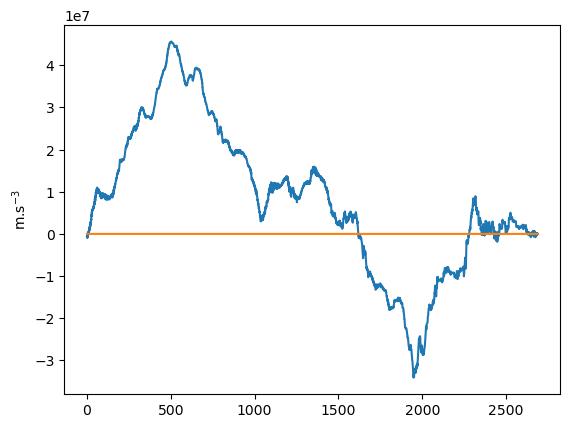

In [193]:
# vol transpEddy_transp_10km
# needs to multiply by 365. Not doing it here. Adele says the eddy vol. transport should be zero,
# but the eddy heat transport not b/c of the nonlinearities involving the product V'.T'
VT_cumsum_eddy_10km = np.cumsum(np.nanmean(np.sum(Eddy_vol_transp_10km, axis=1),axis=0),axis=-1)
VT_cumsum_mean_10km = np.cumsum(vol_transport_10km.sum('s_rho').mean('ocean_time'),axis=-1)

fig = plt.figure()
ax = plt.subplot(111)
plt.plot((VT_cumsum_mean_10km),label='mean') # 10^7
plt.plot(VT_cumsum_eddy_10km,label='eddy')    # 10^-9 (basically zero)
plt.ylabel('m.s$^{-3}$')



Text(0, 0.5, 'm$^{3}$.s')

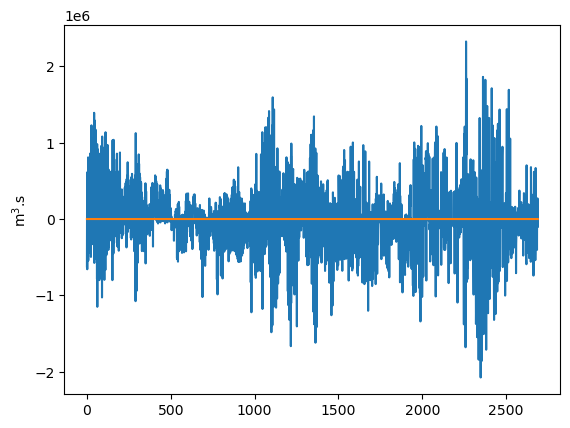

In [194]:
# non-cumm. summed vol transports plots:
VT_eddy_10km = np.nanmean(np.sum(Eddy_vol_transp_10km, axis=1),axis=0)
VT_mean_10km = vol_transport_10km.sum('s_rho').mean('ocean_time')

fig = plt.figure()
ax = plt.subplot(111)
plt.plot((VT_mean_10km),label='mean') # 10^6
plt.plot(VT_eddy_10km,label='eddy')    # 10^-9 also (basically zero)
plt.ylabel('m$^{3}$.s')


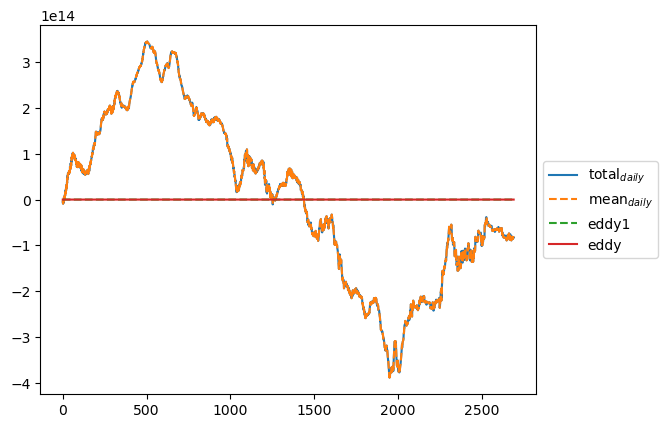

In [247]:
##### total: daily heat_transp, 
cumsum_total_10km = np.cumsum(net_ht_vint_10km,axis=-1).mean('ocean_time')

cumsum_mean_10km = np.cumsum(Mean_transp_10km,axis=-1)
cumsum_mean2_10km = np.cumsum(Mean2_transp_10km.sum('s_rho'),axis=-1)

cumsum_eddy_vint_10km = np.cumsum(np.nanmean(Eddy_transp_vint_10km,axis=0),axis=-1) # 1st annual mean #as below but more smooth
cumsum_eddy1_vint_10km = np.nanmean(np.cumsum(Eddy_transp_vint_10km,axis=-1),axis=0) # 1st cumsum # much more noise than above

fig = plt.figure()
ax = plt.subplot(111)
plt.plot(cumsum_total_10km,label='total$_{daily}$')    # 10^14
plt.plot(cumsum_mean_10km,'--',label='mean$_{daily}$') # 10^14
# plt.plot((cumsum_total_10km-cumsum_mean_10km),label='total$_{daily}$ - mean$_{daily}$') # O(10^0)
plt.plot(cumsum_eddy1_vint_10km,'--',label='eddy1') # 10^-1
plt.plot(cumsum_eddy_vint_10km,label='eddy') # 10^-1
# plt.ylim([-10,4])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


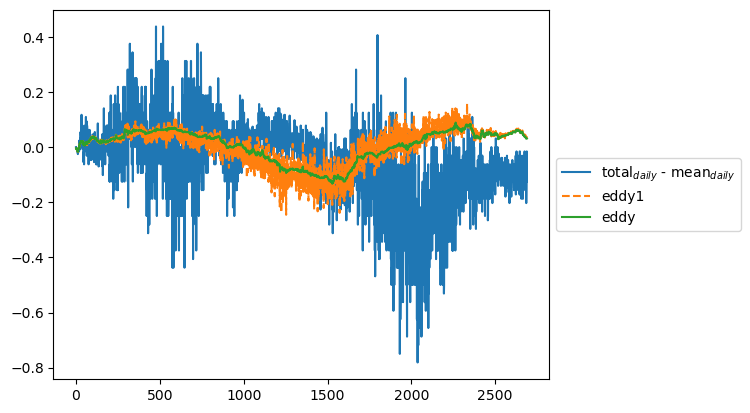

In [246]:
# plot only eddy terms:
#eddy is calculated as diff (daily - annual HT) vert. discretised
#    - then vert-integ, annual avg, cummulatively summed along contour
#eddy vint calculates the diff (daily-annual) with vert-integ.

fig = plt.figure()
ax = plt.subplot(111)
# plt.plot(cumsum_total_10km,label='total$_{daily}$')    # 10^14
# plt.plot(cumsum_mean_10km,'--',label='mean$_{daily}$') # 10^14
plt.plot((cumsum_total_10km-cumsum_mean_10km),label='total$_{daily}$ - mean$_{daily}$') # O(10^-1); this diff comes from the order of annual avg Vs cumsum
plt.plot(cumsum_eddy1_vint_10km,'--',label='eddy1') # 10^-1
plt.plot(cumsum_eddy_vint_10km,label='eddy') # 10^-1

# plt.ylim([-10,4])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


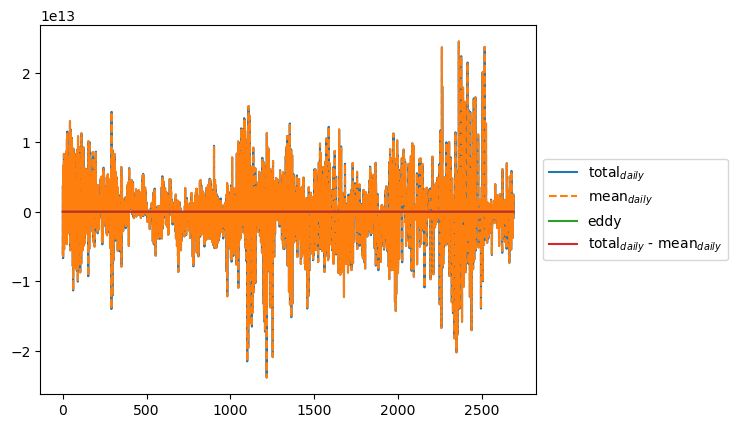

In [249]:
# plots with heat transport w/o cummulative sum:

total_10km = net_ht_vint_10km.mean('ocean_time')

mean_10km = Mean_transp_10km

eddy_vint_10km = np.nanmean(Eddy_transp_vint_10km,axis=0)

fig = plt.figure()
ax = plt.subplot(111)
plt.plot(total_10km,label='total$_{daily}$')    # 10^13
plt.plot(mean_10km,'--',label='mean$_{daily}$') # 10^13
plt.plot(eddy_vint_10km,label='eddy') # 10^-2
plt.plot((total_10km-mean_10km),label='total$_{daily}$ - mean$_{daily}$') # 10^11 -> exacly Zero
# plt.ylim([-10,4])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


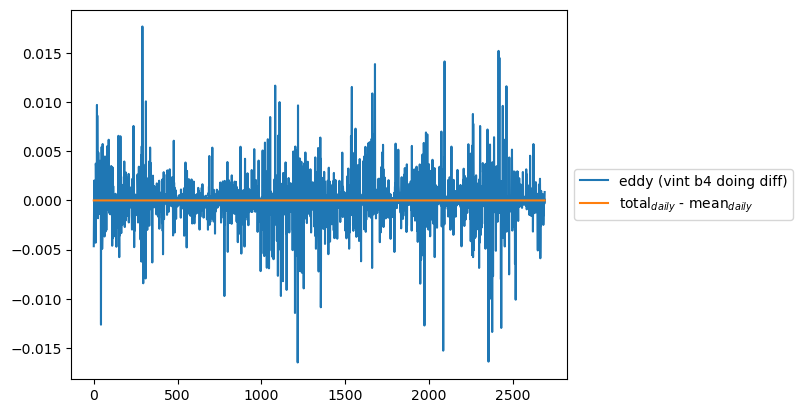

In [250]:
fig = plt.figure()
ax = plt.subplot(111)
# plt.plot(total_10km,label='total$_{daily}$')    # 10^13
# plt.plot(mean_10km,'--',label='mean$_{daily}$') # 10^13
plt.plot(eddy_vint_10km,label='eddy (vint b4 doing diff)') # 10^-2
plt.plot((total_10km-mean_10km),label='total$_{daily}$ - mean$_{daily}$') # EXACTLY ZERO!!!!
# plt.ylim([-10,4])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


NameError: name 'temp3d_vint_10km_annual' is not defined

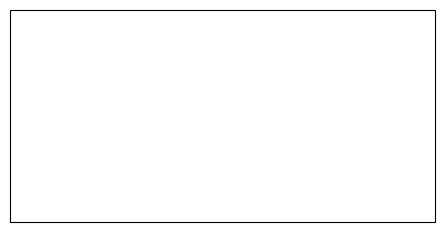

In [243]:
# figure for debugging decompositon, 10km only:
## paper figure with:
# 1) map of OHC depth-integrated
# 2) plot of vertically-integrated  OHT (mean+eddy) across 1500m
# 3) add OHT across CF line below.

### fig, ax = plt.subplots(nrows=2, figsize = (12, 7))
fig = plt.figure(figsize=(12,16))

# 1) map:
jst= 40#100
jen=-1
ist=0
ien=-1
tmin = 0.1
tmax = 0.7
# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
ax2 = fig.add_subplot(511, projection=proj)
ct1=plt.pcolormesh(lon_rho_10km[jst:jen,ist:ien].values,lat_rho_10km[jst:jen,ist:ien].values,temp3d_vint_10km_annual[jst:jen,ist:ien]*1e-9, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_10km,lat_along_10km, s=.8, alpha=0.4, color='turquoise',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10, depth-integrated ocean heat content')

# ax2.gridlines(draw_labels=True,linewidth=.1)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color=[.3,.3,.3], alpha=0.75, linestyle=':')
gl.xlabels_top = False
gl.ylabels_left = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-160, -120, -80, -40, 0, 40, 80, 120, 156])
gl.ylocator = mticker.FixedLocator([-65, -70, -75, -80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 10, 'color': 'k'}
# gl.ylabel_style = {'size': 9, 'color': 'k'}

ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax2.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .2
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.91, 0.76,  0.01, 0.12])
fig.colorbar(ct1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('GJ')#, labelpad=-35)

# 2) Volume transp cross-1500m
ax1 = fig.add_subplot(512)
# ax1.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax1.plot(dist_along_10km[:],np.zeros(VT_cumsum_mean_10km[:].shape),'-', color=[.7,.7,.7], linewidth=1)
ax1.plot(dist_along_10km[:],VT_cumsum_mean_10km,'-',color='dodgerblue', label='Mean', linewidth=1,alpha=1)
ax1.plot(dist_along_10km[:],VT_cumsum_eddy_10km*365,'-',color='orangered', label='Eddy (x365)',linewidth=1,alpha=1)
ax1.plot(dist_along_10km[:],(VT_cumsum_mean_10km+VT_cumsum_eddy_10km*365),'-k', label='Total', linewidth=1,alpha=1)

ax1.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax1.set_xlim(0, dist_along_10km[-1])
ax1.legend()

ymin=-7e7
ymax=7e7
ax1.set_ylim(ymin,ymax)
ax1.plot([dist_along_10km[452].values,dist_along_10km[452].values],[ymin,ymax],'-', color=[.3,.3,.3])     #140W    
ax1.plot([dist_along_10km[918].values,dist_along_10km[918].values],[ymin,ymax],'-', color=[.3,.3,.3])   # 60W                         
ax1.plot([dist_along_10km[1383].values,dist_along_10km[1383].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 25W
ax1.plot([dist_along_10km[2012].values,dist_along_10km[2012].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 60E 
ax1.set_title('Cross-1500m volume transport vertically-integrated (m$^3$ s$^{-1}$)')
ax1.set_ylabel('Volume transport (m$^3$ s$^{-1}$)')

# 3) heat transport 
ax1 = fig.add_subplot(513)
# ax1.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax1.plot(dist_along_10km[:],np.zeros(cumsum_mean_10km[:].shape),'-', color=[.7,.7,.7], linewidth=0.5)
ax1.plot(dist_along_10km[:],cumsum_total_10km,'-',color='gray',label='Total$_{daily}$', linewidth=1,alpha=1)
ax1.plot(dist_along_10km[:],cumsum_total2_10km,':',color='k',label='Total$_{monthly}$', linewidth=1,alpha=1)
ax1.plot(dist_along_10km[:],cumsum_mean_10km,'-',color='dodgerblue',label='Mean$_{daily}$', linewidth=1,alpha=1)
ax1.plot(dist_along_10km[:],cumsum_mean2_10km,'--',color='blue',label='Mean$_{monthly}$', linewidth=1,alpha=1)
ax1.plot(dist_along_10km[:],cumsum_eddy2_10km,'--',color='orangered',label='Eddy2',linewidth=1,alpha=1)
ax1.plot(dist_along_10km[:],(cumsum_total2_10km-cumsum_mean2_10km),'--r',label='Total - Mean (monthly)', linewidth=1,alpha=1)
ax1.legend(loc='lower left')
ax1.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax1.set_xlim(0, dist_along_10km[-1])
ymin=-1000
ymax=500
ax1.set_ylim(ymin,ymax)
ax1.plot([dist_along_10km[452].values,dist_along_10km[452].values],[ymin,ymax],'-', color=[.3,.3,.3])     #140W    
ax1.plot([dist_along_10km[918].values,dist_along_10km[918].values],[ymin,ymax],'-', color=[.3,.3,.3])   # 60W                         
ax1.plot([dist_along_10km[1383].values,dist_along_10km[1383].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 25W
ax1.plot([dist_along_10km[2012].values,dist_along_10km[2012].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 60E 
ax1.set_title('Cross-1500m heat transport vertically-integrated (TW)')
ax1.set_ylabel('Heat transport (TW)')

# 4) heat transport, only eddy components
ax1 = fig.add_subplot(514)
# ax1.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax1.plot(dist_along_10km[:],np.zeros(cumsum_mean_10km[:].shape),'-', color=[.7,.7,.7], linewidth=0.5)
ax1.plot(dist_along_10km[:],cumsum_eddy_10km,'--',color='orange',label='Eddy',linewidth=1,alpha=1)
ax1.plot(dist_along_10km[:],cumsum_eddy2_10km,'-',color='orangered',label='Eddy2',linewidth=1,alpha=1)
ax1.plot(dist_along_10km[:],cumsum_eddy_adv_10km,'--',color='green',label='Eddy$_{adv}$',linewidth=1,alpha=1)
ax1.plot(dist_along_10km[:],cumsum_eddy_10km+cumsum_eddy_adv_10km,'--',color='yellow',label='Eddy + Eddy$_{adv}$',linewidth=1,alpha=1)
ax1.plot(dist_along_10km[:],(cumsum_total2_10km-cumsum_mean2_10km),'-',color='gray',label='Total - Mean (monthly)', linewidth=1,alpha=1)
ax1.legend(loc='lower left')
ax1.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax1.set_xlim(0, dist_along_10km[-1])
ymin=-10
ymax=5
ax1.set_ylim(ymin,ymax)
ax1.plot([dist_along_10km[452].values,dist_along_10km[452].values],[ymin,ymax],'-', color=[.3,.3,.3])     #140W    
ax1.plot([dist_along_10km[918].values,dist_along_10km[918].values],[ymin,ymax],'-', color=[.3,.3,.3])   # 60W                         
ax1.plot([dist_along_10km[1383].values,dist_along_10km[1383].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 25W
ax1.plot([dist_along_10km[2012].values,dist_along_10km[2012].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 60E 
ax1.set_title('Cross-1500m heat transport vertically-integrated (TW)')
ax1.set_ylabel('Heat transport (TW)')

# 5) heat transport, total - mean
plt.plot((cumsum_total_10km-cumsum_mean_10km),label='total$_{daily}$ - mean$_{daily}$')
plt.plot((cumsum_total2_10km-cumsum_mean2_10km),label='total$_{monthly}$ - mean$_{monthly}$')
plt.plot((cumsum_total2_10km-cumsum_mean2_10km)+(cumsum_eddy_10km-cumsum_eddy_adv_10km),'--',label='total$_{monthly}$ - mean$_{monthly}$ + (eddy-eddy$_{adv}$)')
plt.plot((cumsum_total_10km-cumsum_mean_10km)-(cumsum_eddy_10km-cumsum_eddy_adv_10km),'--',label='total$_{daily}$ - mean$_{daily}$ - (eddy-eddy$_{adv}$)')



ax1 = fig.add_subplot(515)
# ax1.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax1.plot(dist_along_10km[:],np.zeros(cumsum_mean_10km[:].shape),'-', color=[.7,.7,.7], linewidth=0.5)
ax1.plot(dist_along_10km[:],(cumsum_total_10km-cumsum_mean_10km),'-',color='k',label='total$_{daily}$ - mean$_{daily}$',linewidth=1,alpha=1)
ax1.plot(dist_along_10km[:],(cumsum_total2_10km-cumsum_mean2_10km),'-',color='gray',label='total$_{monthly}$ - mean$_{monthly}$',linewidth=1,alpha=1)
ax1.plot(dist_along_10km[:],(cumsum_total2_10km-cumsum_mean2_10km)+(cumsum_eddy_10km-cumsum_eddy_adv_10km),'--',color='green',label='total$_{monthly}$ - mean$_{monthly}$ + (eddy-eddy$_{adv}$)',linewidth=1,alpha=1)
ax1.plot(dist_along_10km[:],(cumsum_total_10km-cumsum_mean_10km)-(cumsum_eddy_10km-cumsum_eddy_adv_10km),'--',color='yellow',label='total$_{daily}$ - mean$_{daily}$ - (eddy-eddy$_{adv}$)',linewidth=1,alpha=1)
ax1.legend(loc='lower left')
ax1.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax1.set_xlim(0, dist_along_10km[-1])

ymin=-10
ymax=5
ax1.set_ylim(ymin,ymax)
ax1.plot([dist_along_10km[452].values,dist_along_10km[452].values],[ymin,ymax],'-', color=[.3,.3,.3])     #140W    
ax1.plot([dist_along_10km[918].values,dist_along_10km[918].values],[ymin,ymax],'-', color=[.3,.3,.3])   # 60W                         
ax1.plot([dist_along_10km[1383].values,dist_along_10km[1383].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 25W
ax1.plot([dist_along_10km[2012].values,dist_along_10km[2012].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 60E 
ax1.set_title('Cross-1500m heat transport vertically-integrated (TW)')
ax1.set_ylabel('Heat transport (TW)')


# plt.savefig(fig_path + 'Figure1_OHCvint+_MeanEddy_HTcumsum_cross1500m_v3.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
%time
# WAOM10

Tf = Tf_4km
# Net_heat_transport_4km

# 1a) re-sample to monthly to calculate *seasonal cycle*:
months = p.date_range(start='2007-01-01', end='2007-12-31')
# Create an xarray DataArray with the daily values and datetime index
dt = xr.DataArray(temp_4km, dims=('ocean_time', 's_rho', 'contour_index_array'), coords={'ocean_time': months})
ds = xr.DataArray(salt_4km, dims=('ocean_time', 's_rho', 'contour_index_array'), coords={'ocean_time': months})
dv = xr.DataArray(vol_transport_4km, dims=('ocean_time', 's_rho', 'contour_index_array'), coords={'ocean_time': months})
temp_4km_monthly = dt.resample(ocean_time='1M').mean()
salt_4km_monthly = ds.resample(ocean_time='1M').mean()
vol_transp_4km_monthly = dv.resample(ocean_time='1M').mean()

# 1b) calculate climatological seasonal mean
volxT_4km_season = vol_transp_4km_monthly*(temp_4km_monthly-Tf) # vT x Cp Rho0

# 2) Mean heat transport: average(vol_transp*T)
net_heat_transp_4km = vol_transport_4km*(temp_4km-Tf) # vT x Cp Rho0
Mean_transp_4km = net_heat_transp_4km.mean('ocean_time')

# 4) Eddy heat transport: total - seasonal mean
Months=np.arange(0,365)*(1/30.41667)
Months_flr = np.floor(Months[:])
Eddy_transp_4km = np.empty((0,31,7051))
Eddy_vol_transp_4km = np.empty((0,31,7051))
Eddy_temp_4km = np.empty((0,31,7051))
Eddy_salt_4km = np.empty((0,31,7051))
for mm in np.arange(0,12):
    aa=np.where(mm == Months_flr)
# heat transp
    Eddy_transp_4km_tmp = net_heat_transp_4km[aa[0],:,:] - volxT_4km_season[mm,:,:]
    Eddy_transp_4km = np.concatenate((Eddy_transp_4km_tmp, Eddy_transp_4km), axis=0)
# vol transp
    Eddy_vol_transp_4km_tmp = vol_transport_4km[aa[0],:,:] - vol_transp_4km_monthly[mm,:,:]
    Eddy_vol_transp_4km = np.concatenate((Eddy_vol_transp_4km_tmp, Eddy_vol_transp_4km), axis=0)
# temp:
    Eddy_temp_4km_tmp = (temp_4km[aa[0],:,:]-Tf - temp_4km_monthly[mm,:,:]-Tf)
    Eddy_temp_4km = np.concatenate((Eddy_temp_4km_tmp, Eddy_temp_4km), axis=0)
# salt:
    Eddy_salt_4km_tmp = (salt_4km[aa[0],:,:]) - (salt_4km_monthly[mm,:,:])
    Eddy_salt_4km = np.concatenate((Eddy_salt_4km_tmp, Eddy_salt_4km), axis=0)

Eddy_adv_transp_4km = Eddy_vol_transp_4km*(np.nanmean(temp_4km_monthly, axis=0)-Tf_4km)
Eddy2_transp_4km = Eddy_vol_transp_4km*(Eddy_temp_4km)

dt.close()
ds.close()
dv.close()

In [ ]:
cumsum_total_4km = np.cumsum(net_heat_transp_4km.mean('ocean_time').sum('s_rho'),axis=-1)*rho0*Cp*1e-12
cumsum_total2_4km = np.cumsum(volxT_4km_season.mean('ocean_time').sum('s_rho'),axis=-1)*rho0*Cp*1e-12
mean_ht_4km = (vol_transport_4km.mean('ocean_time'))*(temp_4km.mean('ocean_time')-Tf_4km)
cumsum_mean_4km = np.cumsum(mean_ht_4km.sum('s_rho'),axis=-1)*rho0*Cp*1e-12

mean2_ht_4km = (vol_transp_4km_monthly.mean('ocean_time'))*(temp_4km_monthly.mean('ocean_time')-Tf_4km)
cumsum_mean2_4km = np.cumsum(mean2_ht_4km.sum('s_rho'),axis=-1)*rho0*Cp*1e-12

cumsum_eddy_4km = np.cumsum(np.nanmean(np.sum(Eddy_transp_4km, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12
cumsum_eddy2_4km = np.cumsum(np.sum(np.nanmean(Eddy2_transp_4km, axis=0),axis=0),axis=-1)*rho0*Cp*1e-12
cumsum_eddy_adv_4km = np.cumsum(np.sum(np.nanmean(Eddy_adv_transp_4km, axis=0),axis=0),axis=-1)*rho0*Cp*1e-12

fig = plt.figure()
ax = plt.subplot(111)
plt.plot(cumsum_total_4km,label='total$_{daily}$')
plt.plot(cumsum_total2_4km,label='total$_{monthly}$')
plt.plot(cumsum_mean_4km,'--',label='mean$_{daily}$')
plt.plot(cumsum_mean2_4km,':',label='mean$_{monthly}$')
plt.plot(cumsum_eddy_4km,label='eddy')
plt.plot(cumsum_eddy2_4km,label='eddy2')
plt.plot(cumsum_eddy_4km+cumsum_eddy_adv_4km,label='eddy + eddy$_{adv}$')
plt.plot(cumsum_eddy_adv_4km,label='eddy$_{adv}$')
plt.plot((cumsum_total_4km-cumsum_mean_4km),label='total$_{daily}$ - mean$_{daily}$')
# plt.plot((cumsum_total_4km-cumsum_mean2_4km),label='total$_{daily}$ - mean$_{monthly}$')
plt.plot((cumsum_total2_4km-cumsum_mean2_4km),label='total$_{monthly}$ - mean$_{monthly}$')
plt.plot((cumsum_total2_4km-cumsum_mean2_4km)+cumsum_eddy_4km,label='total$_{monthly}$ - mean$_{monthly}$ + eddy')
plt.plot((cumsum_total_4km-cumsum_mean_4km)-cumsum_eddy_4km,label='total$_{daily}$ - mean$_{daily}$ - eddy')

# plt.plot((cumsum_total2_4km-cumsum_mean2_4km)+cumsum_eddy2_4km,label='NET')


plt.ylim([-15,15])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(cumsum_eddy_4km,label='eddy')
plt.plot(cumsum_eddy2_4km,label='eddy2')
plt.plot(cumsum_eddy_4km+cumsum_eddy_adv_4km,label='eddy + eddy$_{adv}$')
plt.plot(cumsum_eddy_adv_4km,label='eddy$_{adv}$')
plt.title('eddy2 = eddy + eddy$_{adv}$')

plt.ylim([-10,4])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
# plt.plot(cumsum_eddy_4km,label='eddy')
plt.plot((cumsum_total_4km-cumsum_mean_4km),label='total$_{daily}$ - mean$_{daily}$')
plt.plot((cumsum_total2_4km-cumsum_mean2_4km),label='total$_{monthly}$ - mean$_{monthly}$')
plt.plot((cumsum_total2_4km-cumsum_mean2_4km)+(cumsum_eddy_4km-cumsum_eddy_adv_4km),'--',label='total$_{monthly}$ - mean$_{monthly}$ + (eddy-eddy$_{adv}$)')
plt.plot((cumsum_total_4km-cumsum_mean_4km)-(cumsum_eddy_4km-cumsum_eddy_adv_4km),'--',label='total$_{daily}$ - mean$_{daily}$ - (eddy-eddy$_{adv}$)')

plt.title('Res eddy (monthly) = Res eddy (daily)  - (eddy (daily) - eddy$_{adv}$) \n Res eddy (daily)  = Res eddy (monthly) + (eddy (daily) - eddy$_{adv}$)')
plt.ylim([-15,15])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [ ]:
# figure for debugging decompositon, 4km only:
## paper figure with:
# 1) map of OHC depth-integrated
# 2) plot of vertically-integrated  OHT (mean+eddy) across 1500m
# 3) add OHT across CF line below.

### fig, ax = plt.subplots(nrows=2, figsize = (12, 7))
fig = plt.figure(figsize=(12,16))

# 1) map:
jst= 100
jen=-1
ist=0
ien=-1
tmin = 0.1
tmax = 0.7
# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
ax2 = fig.add_subplot(511, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km[jst:jen,ist:ien].values,lat_rho_4km[jst:jen,ist:ien].values,temp3d_vint_4km_annual[jst:jen,ist:ien]*1e-9, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.4, color='turquoise',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM4, depth-integrated ocean heat content')

# ax2.gridlines(draw_labels=True,linewidth=.1)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color=[.3,.3,.3], alpha=0.75, linestyle=':')
gl.xlabels_top = False
gl.ylabels_left = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-160, -120, -80, -40, 0, 40, 80, 120, 156])
gl.ylocator = mticker.FixedLocator([-65, -70, -75, -80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 10, 'color': 'k'}
# gl.ylabel_style = {'size': 9, 'color': 'k'}

ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax2.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .2
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.91, 0.76,  0.01, 0.12])
fig.colorbar(ct1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('GJ')#, labelpad=-35)

# 2) Volume transp cross-1500m
ax1 = fig.add_subplot(512)
# ax1.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax1.plot(dist_along_4km[:],np.zeros(VT_cumsum_mean_4km[:].shape),'-', color=[.7,.7,.7], linewidth=1)
ax1.plot(dist_along_4km[:],VT_cumsum_mean_4km,'-',color='dodgerblue', label='Mean', linewidth=1,alpha=1)
ax1.plot(dist_along_4km[:],VT_cumsum_eddy_4km*365,'-',color='orangered', label='Eddy (x365)',linewidth=1,alpha=1)
ax1.plot(dist_along_4km[:],(VT_cumsum_mean_4km+VT_cumsum_eddy_4km*365),'-k', label='Total', linewidth=1,alpha=1)

ax1.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax1.set_xlim(0, dist_along_4km[-1])
ax1.legend()

ymin=-7e7
ymax=7e7
ax1.set_ylim(ymin,ymax)
ax1.plot([dist_along_4km[452].values,dist_along_4km[452].values],[ymin,ymax],'-', color=[.3,.3,.3])     #140W    
ax1.plot([dist_along_4km[918].values,dist_along_4km[918].values],[ymin,ymax],'-', color=[.3,.3,.3])   # 60W                         
ax1.plot([dist_along_4km[1383].values,dist_along_4km[1383].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 25W
ax1.plot([dist_along_4km[2012].values,dist_along_4km[2012].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 60E 
ax1.set_title('Cross-1500m volume transport vertically-integrated (m$^3$ s$^{-1}$)')
ax1.set_ylabel('Volume transport (m$^3$ s$^{-1}$)')

# 3) heat transport 
ax1 = fig.add_subplot(513)
# ax1.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax1.plot(dist_along_4km[:],np.zeros(cumsum_mean_4km[:].shape),'-', color=[.7,.7,.7], linewidth=0.5)
ax1.plot(dist_along_4km[:],cumsum_total_4km,'-',color='gray',label='Total$_{daily}$', linewidth=1,alpha=1)
ax1.plot(dist_along_4km[:],cumsum_total2_4km,':',color='k',label='Total$_{monthly}$', linewidth=1,alpha=1)
ax1.plot(dist_along_4km[:],cumsum_mean_4km,'-',color='dodgerblue',label='Mean$_{daily}$', linewidth=1,alpha=1)
ax1.plot(dist_along_4km[:],cumsum_mean2_4km,'--',color='blue',label='Mean$_{monthly}$', linewidth=1,alpha=1)
ax1.plot(dist_along_4km[:],cumsum_eddy2_4km,'--',color='orangered',label='Eddy2',linewidth=1,alpha=1)
ax1.plot(dist_along_4km[:],(cumsum_total2_4km-cumsum_mean2_4km),'--r',label='Total - Mean (monthly)', linewidth=1,alpha=1)
ax1.legend(loc='lower left')
ax1.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax1.set_xlim(0, dist_along_4km[-1])
ymin=-1000
ymax=500
ax1.set_ylim(ymin,ymax)
ax1.plot([dist_along_4km[452].values,dist_along_4km[452].values],[ymin,ymax],'-', color=[.3,.3,.3])     #140W    
ax1.plot([dist_along_4km[918].values,dist_along_4km[918].values],[ymin,ymax],'-', color=[.3,.3,.3])   # 60W                         
ax1.plot([dist_along_4km[1383].values,dist_along_4km[1383].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 25W
ax1.plot([dist_along_4km[2012].values,dist_along_4km[2012].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 60E 
ax1.set_title('Cross-1500m heat transport vertically-integrated (TW)')
ax1.set_ylabel('Heat transport (TW)')

# 4) heat transport, only eddy components
ax1 = fig.add_subplot(514)
# ax1.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax1.plot(dist_along_4km[:],np.zeros(cumsum_mean_4km[:].shape),'-', color=[.7,.7,.7], linewidth=0.5)
ax1.plot(dist_along_4km[:],cumsum_eddy_4km,'--',color='orange',label='Eddy',linewidth=1,alpha=1)
ax1.plot(dist_along_4km[:],cumsum_eddy2_4km,'-',color='orangered',label='Eddy2',linewidth=1,alpha=1)
ax1.plot(dist_along_4km[:],cumsum_eddy_adv_4km,'--',color='green',label='Eddy$_{adv}$',linewidth=1,alpha=1)
ax1.plot(dist_along_4km[:],cumsum_eddy_4km+cumsum_eddy_adv_4km,'--',color='yellow',label='Eddy + Eddy$_{adv}$',linewidth=1,alpha=1)
ax1.plot(dist_along_4km[:],(cumsum_total2_4km-cumsum_mean2_4km),'-',color='gray',label='Total - Mean (monthly)', linewidth=1,alpha=1)
ax1.legend(loc='lower left')
ax1.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax1.set_xlim(0, dist_along_4km[-1])
ymin=-10
ymax=5
ax1.set_ylim(ymin,ymax)
ax1.plot([dist_along_4km[452].values,dist_along_4km[452].values],[ymin,ymax],'-', color=[.3,.3,.3])     #140W    
ax1.plot([dist_along_4km[918].values,dist_along_4km[918].values],[ymin,ymax],'-', color=[.3,.3,.3])   # 60W                         
ax1.plot([dist_along_4km[1383].values,dist_along_4km[1383].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 25W
ax1.plot([dist_along_4km[2012].values,dist_along_4km[2012].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 60E 
ax1.set_title('Cross-1500m heat transport vertically-integrated (TW)')
ax1.set_ylabel('Heat transport (TW)')

# 5) heat transport, total - mean
plt.plot((cumsum_total_4km-cumsum_mean_4km),label='total$_{daily}$ - mean$_{daily}$')
plt.plot((cumsum_total2_4km-cumsum_mean2_4km),label='total$_{monthly}$ - mean$_{monthly}$')
plt.plot((cumsum_total2_4km-cumsum_mean2_4km)+(cumsum_eddy_4km-cumsum_eddy_adv_4km),'--',label='total$_{monthly}$ - mean$_{monthly}$ + (eddy-eddy$_{adv}$)')
plt.plot((cumsum_total_4km-cumsum_mean_4km)-(cumsum_eddy_4km-cumsum_eddy_adv_4km),'--',label='total$_{daily}$ - mean$_{daily}$ - (eddy-eddy$_{adv}$)')



ax1 = fig.add_subplot(515)
# ax1.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax1.plot(dist_along_4km[:],np.zeros(cumsum_mean_4km[:].shape),'-', color=[.7,.7,.7], linewidth=0.5)
ax1.plot(dist_along_4km[:],(cumsum_total_4km-cumsum_mean_4km),'-',color='k',label='total$_{daily}$ - mean$_{daily}$',linewidth=1,alpha=1)
ax1.plot(dist_along_4km[:],(cumsum_total2_4km-cumsum_mean2_4km),'-',color='gray',label='total$_{monthly}$ - mean$_{monthly}$',linewidth=1,alpha=1)
ax1.plot(dist_along_4km[:],(cumsum_total2_4km-cumsum_mean2_4km)+(cumsum_eddy_4km-cumsum_eddy_adv_4km),'--',color='green',label='total$_{monthly}$ - mean$_{monthly}$ + (eddy-eddy$_{adv}$)',linewidth=1,alpha=1)
ax1.plot(dist_along_4km[:],(cumsum_total_4km-cumsum_mean_4km)-(cumsum_eddy_4km-cumsum_eddy_adv_4km),'--',color='yellow',label='total$_{daily}$ - mean$_{daily}$ - (eddy-eddy$_{adv}$)',linewidth=1,alpha=1)
ax1.legend(loc='lower left')
ax1.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax1.set_xlim(0, dist_along_4km[-1])

ymin=-10
ymax=5
ax1.set_ylim(ymin,ymax)
ax1.plot([dist_along_4km[452].values,dist_along_4km[452].values],[ymin,ymax],'-', color=[.3,.3,.3])     #140W    
ax1.plot([dist_along_4km[918].values,dist_along_4km[918].values],[ymin,ymax],'-', color=[.3,.3,.3])   # 60W                         
ax1.plot([dist_along_4km[1383].values,dist_along_4km[1383].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 25W
ax1.plot([dist_along_4km[2012].values,dist_along_4km[2012].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 60E 
ax1.set_title('Cross-1500m heat transport vertically-integrated (TW)')
ax1.set_ylabel('Heat transport (TW)')


# plt.savefig(fig_path + 'Figure1_OHCvint+_MeanEddy_HTcumsum_cross1500m_v3.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
plt.pcolormesh((temp_10km.isel(ocean_time=0)-Tf_10km)-np.nanmean(temp_10km-Tf_10km, axis=0),vmin=-.5, vmax=.5)#,vmin=0, vmax=6)
plt.colorbar()

In [ ]:
print(temp_10km.shape, Eddy_vol_transp_10km.shape)
# testing eddy_vol_transp*temp




In [ ]:
plt.pcolormesh(Eddy_transp_10km[200,:])
# plt.pcolormesh(np.nanmean(Eddy_transp_10km, axis=0))
plt.colorbar()

In [ ]:
plt.pcolormesh(Eddy2_transp_10km[200,:])
# plt.pcolormesh(np.nanmean(Eddy2_transp_10km, axis=0))
plt.colorbar()

In [ ]:
%%time


# 1) define variable cumsum along contour:
cumsum_mean_10km = np.cumsum(net_heat_transp_10km.mean('ocean_time').sum('s_rho'),axis=-1)*rho0*Cp*1e-12
cumsum_mean_4km = np.cumsum(net_heat_transp_4km.mean('ocean_time').sum('s_rho'),axis=-1)*rho0*Cp*1e-12
cumsum_eddy_10km = np.cumsum(np.nanmean(np.nansum(Eddy_transp_10km, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12
cumsum_eddy2_10km = np.cumsum(np.nanmean(np.nansum(Eddy2_transp_10km, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12
cumsum_eddy_4km = np.cumsum(np.nanmean(np.nansum(Eddy_transp_4km, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12
cumsum_eddy2_4km = np.cumsum(np.nanmean(np.nansum(Eddy2_transp_4km, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12
cumsum_Tf_10km = np.cumsum(Tf_heat_transp_10km.mean('ocean_time').sum('s_rho'),axis=-1)*rho0*Cp*1e-12
cumsum_Tf_4km = np.cumsum(Tf_heat_transp_4km.mean('ocean_time').sum('s_rho'),axis=-1)*rho0*Cp*1e-12



# vol transpEddy_transp_10km; needs to multiply by 365
VT_cumsum_eddy_10km = np.cumsum(np.nanmean(np.nansum(Eddy_vol_transp_10km, axis=1),axis=0),axis=-1)
VT_cumsum_mean_10km = np.cumsum(vol_transport_10km.mean('ocean_time').sum('s_rho'),axis=-1)
VT_cumsum_eddy_4km = np.cumsum(np.nanmean(np.nansum(Eddy_vol_transp_4km, axis=1),axis=0),axis=-1)
VT_cumsum_mean_4km = np.cumsum(vol_transport_4km.mean('ocean_time').sum('s_rho'),axis=-1)


In [ ]:
# plt.plot(cumsum_Tf_10km,label='Tf')
plt.plot(cumsum_mean_10km,label='mean')
plt.plot(cumsum_eddy_10km,label='eddy')
# plt.plot(cumsum_eddy2_10km,label='eddy2')
# plt.plot(cumsum_eddy_10km-cumsum_eddy2_10km,label='diff')
plt.plot((cumsum_eddy_10km)-cumsum_mean_10km,'-k',label='NET')
plt.legend()

In [ ]:
# plt.plot(cumsum_Tf_4km,label='Tf')
# plt.plot(cumsum_mean_4km,label='mean')
plt.plot(cumsum_eddy_4km,label='eddy')
plt.plot(cumsum_eddy2_4km,label='eddy2')
plt.plot(cumsum_eddy_4km-cumsum_eddy2_4km,label='diff')
# plt.plot((cumsum_eddy_4km-cumsum_eddy2_4km)+cumsum_mean_4km,'-k',label='NET')
plt.legend()

In [ ]:
%%time

# 2) calculate OHC depth-integrated:
temp3d_4km.load()
temp3d_4km_K = temp3d_4km-Tf_4km
temp3d_vint_4km_annual = temp3d_4km_K.sum('s_rho').mean('ocean_time')*rho0*Cp
print(temp3d_vint_4km_annual.shape)

temp3d_10km.load()
temp3d_10km_K = temp3d_10km-Tf_10km
temp3d_vint_10km_annual = temp3d_10km_K.sum('s_rho').mean('ocean_time')*rho0*Cp
print(temp3d_vint_10km_annual.shape)


In [ ]:
## paper figure with:
# 1) map of OHC depth-integrated
# 2) plot of vertically-integrated  OHT (mean+eddy) across 1500m
# 3) add OHT across CF line below.

### fig, ax = plt.subplots(nrows=2, figsize = (12, 7))
fig = plt.figure(figsize=(12,16))

# 1) map:
jst= 100
jen=-1
ist=0
ien=-1
tmin = 0
tmax = 0.5
# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
ax2 = fig.add_subplot(411, projection=proj)
ct1=plt.pcolormesh(lon_rho_4km[jst:jen,ist:ien].values,lat_rho_4km[jst:jen,ist:ien].values,temp3d_vint_4km_annual[jst:jen,ist:ien]*1e-9, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmin=tmin, vmax=tmax)
plt.scatter(lon_along_4km,lat_along_4km, s=.8, alpha=0.4, color='turquoise',label='1500m isobath', transform=ccrs.PlateCarree());
# plt.scatter(lon_along_4km_CF,lat_along_4km_CF, s=.8, alpha=0.4, color='lightskyblue',label='Calving front', transform=ccrs.PlateCarree());
plt.title('WAOM4, depth-integrated ocean heat content')

# ax2.gridlines(draw_labels=True,linewidth=.1)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=.5, color=[.3,.3,.3], alpha=0.75, linestyle=':')
gl.xlabels_top = False
gl.ylabels_left = True
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-160, -120, -80, -40, 0, 40, 80, 120, 156])
gl.ylocator = mticker.FixedLocator([-65, -70, -75, -80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 10, 'color': 'k'}
# gl.ylabel_style = {'size': 9, 'color': 'k'}

ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax2.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .2
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.91, 0.674,  0.01, 0.18])
fig.colorbar(ct1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('GJ')#, labelpad=-35)

# 2) Volume transp cross-1500m
ax1 = fig.add_subplot(412)
# ax1.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax1.plot(dist_along_10km[:],np.zeros(VT_cumsum_mean_10km[:].shape),'-', color=[.7,.7,.7], linewidth=0.5)
ax1.plot(dist_along_10km[:],(VT_cumsum_mean_10km+VT_cumsum_eddy_10km),'--k', label='WAOM10', linewidth=1,alpha=0.7)
ax1.plot(dist_along_4km[0],(VT_cumsum_mean_4km[0]+VT_cumsum_eddy_4km[0]),'-k',label='WAOM4', linewidth=1.6) # plot just to add legend
# ax1.legend(loc='upper left')
ax1.plot(dist_along_10km[:],VT_cumsum_mean_10km,'--',color='dodgerblue', linewidth=1,alpha=0.6)
ax1.plot(dist_along_10km[:],VT_cumsum_eddy_10km,'--',color='orangered',linewidth=1,alpha=0.6)
ax1.plot(dist_along_10km[:],(VT_cumsum_mean_10km+VT_cumsum_eddy_10km),'--k', linewidth=1,alpha=0.7)

ax1.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax1.set_xlim(0, dist_along_10km[-1])

ax1b = ax1.twiny()
ax1b.plot(dist_along_4km[:],(VT_cumsum_mean_4km+VT_cumsum_eddy_4km),'-k',label='NET', linewidth=1.6)
ax1b.plot(dist_along_4km[:],VT_cumsum_eddy_4km,'-',label='EDDY',color='orangered',linewidth=1.6)
ax1b.plot(dist_along_4km[:],VT_cumsum_mean_4km,'-',label='MEAN',color='dodgerblue',linewidth=1.6)
# ax1b.legend(loc='upper right')
ax1b.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
ax1b.set_xticklabels((''))
ax1b.set_xlim(0, dist_along_4km[-1])

ymin=-6e7
ymax=6e7
ax1.set_ylim(ymin,ymax)
# ax1.text(dist_along_10km[452].values-2.5,ymin-50,'$\it{Ross}$',fontsize=12, color='k')       
ax1.plot([dist_along_10km[452].values,dist_along_10km[452].values],[ymin,ymax],'-', color=[.3,.3,.3])     #140W    
# ax1.text(dist_along_10km[452].values+.5,ymin-50,'$\it{West\ Ant.}$',fontsize=12, color='k')             
ax1.plot([dist_along_10km[918].values,dist_along_10km[918].values],[ymin,ymax],'-', color=[.3,.3,.3])   # 60W                         
# ax1.text(dist_along_10km[918].values+.5,ymin-50,'$\it{FRIS}$',fontsize=12, color='k')        
ax1.plot([dist_along_10km[1383].values,dist_along_10km[1383].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 25W
# ax1.text(dist_along_10km[1383].values+1.25,ymin-50,'$\it{Maud\ Land}$',fontsize=12, color='k')        
ax1.plot([dist_along_10km[2012].values,dist_along_10km[2012].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 60E 
# ax1.text(dist_along_10km[2012].values+2,ymin-50,'$\it{East\ Ant.}$',fontsize=12, color='k')   
ax1.set_title('Cross-1500m volume transport vertically-integrated (m$^3$ s$^{-1}$)')
ax1.set_ylabel('Volume transport (m$^3$ s$^{-1}$)')

# 3) heat transport 
ax1 = fig.add_subplot(412)
# ax1.text(2,75,'Annual mean and eddy heat transport',fontsize=16)
ax1.plot(dist_along_10km[:],np.zeros(cumsum_mean_10km[:].shape),'-', color=[.7,.7,.7], linewidth=0.5)
ax1.plot(dist_along_10km[:],(cumsum_mean_10km+cumsum_eddy2_10km),'--k', label='WAOM10', linewidth=1,alpha=0.7)
# ax1.plot(dist_along_4km[0],(cumsum_mean_4km[0]+cumsum_eddy2_4km[0]),'-k',label='WAOM4', linewidth=1.6) # plot just to add legend
# ax1.plot(dist_along_4km[0],(cumsum_mean_4kmNT[0]+cumsum_eddy_4kmNT[0]),':k',label='WAOM4-NOTIDE', linewidth=1,alpha=0.7)  # plot just to add legend
ax1.legend(loc='upper left')
ax1.plot(dist_along_10km[:],cumsum_mean_10km,'--',color='dodgerblue',label='Mean', linewidth=1,alpha=0.6)
ax1.plot(dist_along_10km[:],cumsum_eddy2_10km,'--',color='orangered',label='Eddy',linewidth=1,alpha=0.6)
ax1.plot(dist_along_10km[:],(cumsum_mean_10km+cumsum_eddy2_10km),'--k',label='Net', linewidth=1,alpha=0.7)
ax1.legend(loc='upper right')

ax1.set_xticks(dist_along_10km[distance_indices_10km.astype(int)[:]])
ax1.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax1.set_xlim(0, dist_along_10km[-1])

# ax1b = ax1.twiny()
# ax1b.plot(dist_along_4km[:],(cumsum_mean_4km+cumsum_eddy2_4km),'-k',label='NET', linewidth=1.6)
# ax1b.plot(dist_along_4km[:],cumsum_eddy2_4km,'-',label='EIT',color='orangered',linewidth=1.6)
# ax1b.plot(dist_along_4km[:],cumsum_mean_4km,'-',label='ADV',color='dodgerblue',linewidth=1.6)
# # ax1b.plot(dist_along_4km[:],cumsum_Tf_4km,'-m', label='Tf HT', linewidth=1.6)
# ax1b.set_xticks(dist_along_4km[distance_indices_4km.astype(int)[:]])
# ax1b.set_xticklabels((''))
# ax1b.set_xlim(0, dist_along_4km[-1])
ax1b.legend(loc='upper right')

ymin=-1000
ymax=1000
ax1.set_ylim(ymin,ymax)
ax1.plot([dist_along_10km[452].values,dist_along_10km[452].values],[ymin,ymax],'-', color=[.3,.3,.3])     #140W    
ax1.plot([dist_along_10km[918].values,dist_along_10km[918].values],[ymin,ymax],'-', color=[.3,.3,.3])   # 60W                         
ax1.plot([dist_along_10km[1383].values,dist_along_10km[1383].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 25W
ax1.plot([dist_along_10km[2012].values,dist_along_10km[2012].values],[ymin,ymax],'-', color=[.3,.3,.3])     # 60E 
ax1.set_title('Cross-1500m heat transport vertically-integrated (TW)')
ax1.set_ylabel('Heat transport (TW)')




# plt.savefig(fig_path + 'Figure1_OHCvint+_MeanEddy_HTcumsum_cross1500m_v3.png', bbox_inches='tight', dpi=300)
plt.show()

### NOTES ON 19/03/24

The eddy calculation doesn't match in order of magnitude with the mean transport (either volume or heat); multiplying these by 365 (days) does bring them to similar magnitudes - but I couldn't rationalise applying that ratio.

Taking the above attempt as correct, we then can replicated similar circumpolar cummulatively summed transport along the 1500m isobath in terms of mean and eddy advection.
This assumes 

\begin{equation}
U^{eddy} = Vol\ Transp_{eddy}\ =\ Vol\ Transp_{daily}\ - Vol\ Trans_{seas}.
\end{equation}

and the eddy advection component is given by:

\begin{equation}
\Phi^{eddy}_{adv} = \rho C_p \int^{0}_{-h} \overline{U^{eddy}} (z') \left[  \bar{T}(z') - T_f \right]
\end{equation}

Following Paloczy et al. (2018, JGR), the eddy streamfunction $\Psi^{eddy}$ (Neutral Density Transformed Eulerian Mean overturning streamfunction; Stewart & Thompson, 2015a) is calculated by:

\begin{equation}
\Psi^{eddy} = \frac{ \overline{\beta} \overline{U'S'} - \overline{\alpha} \overline{U'T'} }{ \overline{\beta} \frac{\partial{\overline{S}}}{\partial z} - \overline{\alpha} \frac{\partial{\overline{T}}}{\partial z} }
\end{equation}

where $\beta$ and $\alpha$ are the thermal expansion haline contraction coefficients, $U$ are the cross-contour transport, $S$ and $T$ the salinity and temperature fields, overbars indicate time-mean and primes indicate deviations around the mean. From the eddy streamfunction, we can then calculate:

\begin{equation}
U^{eddy} = - \partial_{z} \Psi^{eddy}
\end{equation}


1. calculate beta and alpha from mean(T)/mean(S):


In [ ]:
# gsw.specvol_alpha_beta(SA, CT, p)

specvol_10km, alpha_10km, beta_10km = gsw.specvol_alpha_beta(np.nanmean(salt_10km, axis=0), np.nanmean(temp_10km-Tf_10km, axis=0), np.nanmean(z_rho_10km, axis=0))
specvol_4km, alpha_4km, beta_4km = gsw.specvol_alpha_beta(np.nanmean(salt_4km, axis=0), np.nanmean(temp_4km-Tf_4km, axis=0), np.nanmean(z_rho_4km, axis=0))


In [ ]:
# plot sample

fig = plt.figure(figsize=(6,5))
plt.pcolormesh(alpha_10km)
plt.colorbar()

plt.show()

2. now getting $\overline{U'S'}$ and $\overline{U'T'}$:

In [ ]:
# U' = vol_transp(daily) - vol_transp(monthly)
# T' = temp(daily) - temp(monthly)
UTeddy_10km = Eddy_vol_transp_10km*Eddy_temp_10km
USeddy_10km = Eddy_vol_transp_10km*Eddy_salt_10km

UTeddy_4km = Eddy_vol_transp_4km*Eddy_temp_4km
USeddy_4km = Eddy_vol_transp_4km*Eddy_salt_4km

## these are the equivalent to eddy2 calculated above;

In [ ]:
Eddy_vol_transp_10km.shape

In [ ]:
# plot sample
fig = plt.figure(figsize=(10,3.5))
plt.plot(np.nanmean(np.sum(vol_transport_10km, axis=1), axis=0))
plt.plot(np.sum(Eddy_vol_transp_10km, axis=1)[-1,:])
plt.plot(np.nanmean(np.sum(Eddy_vol_transp_10km, axis=1), axis=0),'--')
plt.show()

3. now calculating $\frac{\partial{\overline{S}}}{\partial z}$ and $\frac{\partial{\overline{T}}}{\partial z}$:

In [327]:
Svgrad_10km = np.gradient(np.nanmean(salt_10km, axis=0), axis=1)
Tvgrad_10km = np.gradient(np.nanmean(temp_10km-Tf_10km, axis=0), axis=1)

Svgrad_4km = np.gradient(np.nanmean(salt_4km, axis=0), axis=1)
Tvgrad_4km = np.gradient(np.nanmean(temp_4km-Tf_4km, axis=0), axis=1)


4. calculating $\Psi^{eddy}$:

In [328]:
Psi_eddy_tmp1 = (beta_10km*USeddy_10km) - (alpha_10km*UTeddy_10km)
Psi_eddy_tmp2 = (beta_10km*Svgrad_10km) - (alpha_10km*Tvgrad_10km)
Psi_eddy_10km = np.divide(Psi_eddy_tmp1,Psi_eddy_tmp2)
del Psi_eddy_tmp1, Psi_eddy_tmp2

Psi_eddy_tmp1 = (beta_4km*USeddy_4km) - (alpha_4km*UTeddy_4km)
Psi_eddy_tmp2 = (beta_4km*Svgrad_4km) - (alpha_4km*Tvgrad_4km)
Psi_eddy_4km = np.divide(Psi_eddy_tmp1,Psi_eddy_tmp2)
# del Psi_eddy_tmp1, Psi_eddy_tmp2


5. now calculating $\overline{U^{eddy}}$ by vertical gradient of $\Psi^{eddy}$

In [329]:
Ueddy_10km = np.gradient(Psi_eddy_10km, axis=1)
Ueddy_4km = np.gradient(Psi_eddy_4km, axis=1)

new estimate for eddy advection based on $Psi^{eddy}$:

In [330]:
Eddy_adv_10km = Ueddy_10km*(np.nanmean(temp_10km, axis=0)-Tf_10km)
Eddy_adv_4km = Ueddy_4km*(np.nanmean(temp_4km, axis=0)-Tf_4km)

In [331]:
Ueddy_10km.shape

(365, 31, 2688)

In [332]:
%%time

# 1) define variable cumsum along contour:
cumsum_eddy_adv_10km = np.cumsum(np.nanmean(np.nansum(Eddy_adv_10km, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12
cumsum_eddy_adv_4km  = np.cumsum(np.nanmean(np.nansum(Eddy_adv_4km , axis=1),axis=0),axis=-1)*rho0*Cp*1e-12


CPU times: user 431 ms, sys: 273 ms, total: 704 ms
Wall time: 589 ms


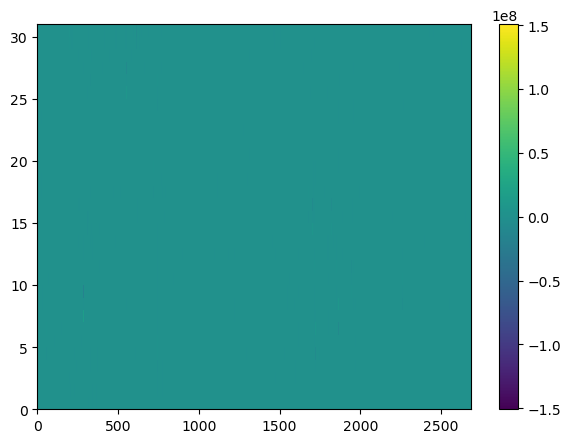

In [345]:
fig = plt.figure(figsize=(7,5))
# plt.pcolormesh(np.nanmean(np.divide(Psi_eddy_tmp1,Psi_eddy_tmp2),axis=0), vmin=-1e8, vmax=1e8)
# plt.pcolormesh(np.nanmean(Psi_eddy_tmp1,axis=0))
plt.pcolormesh(np.nanmean(Ueddy_10km,axis=0))
plt.colorbar()

plt.show()

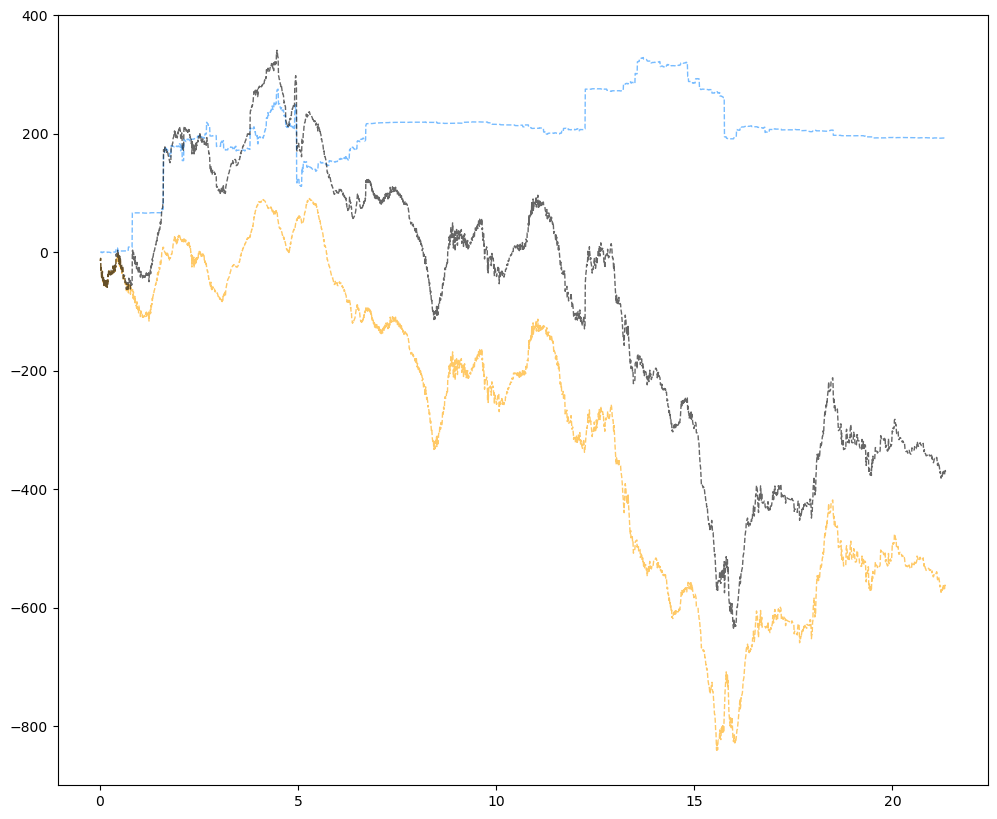

In [334]:
fig = plt.figure(figsize=(12,10))
plt.plot(dist_along_10km[:],cumsum_eddy_adv_10km,'--',color='dodgerblue', linewidth=1,alpha=0.6)
plt.plot(dist_along_10km[:],cumsum_mean_10km,'--',color='orange', linewidth=1,alpha=0.6)
plt.plot(dist_along_10km[:],cumsum_mean_10km+cumsum_eddy_adv_10km,'--',color='black', linewidth=1,alpha=0.6)


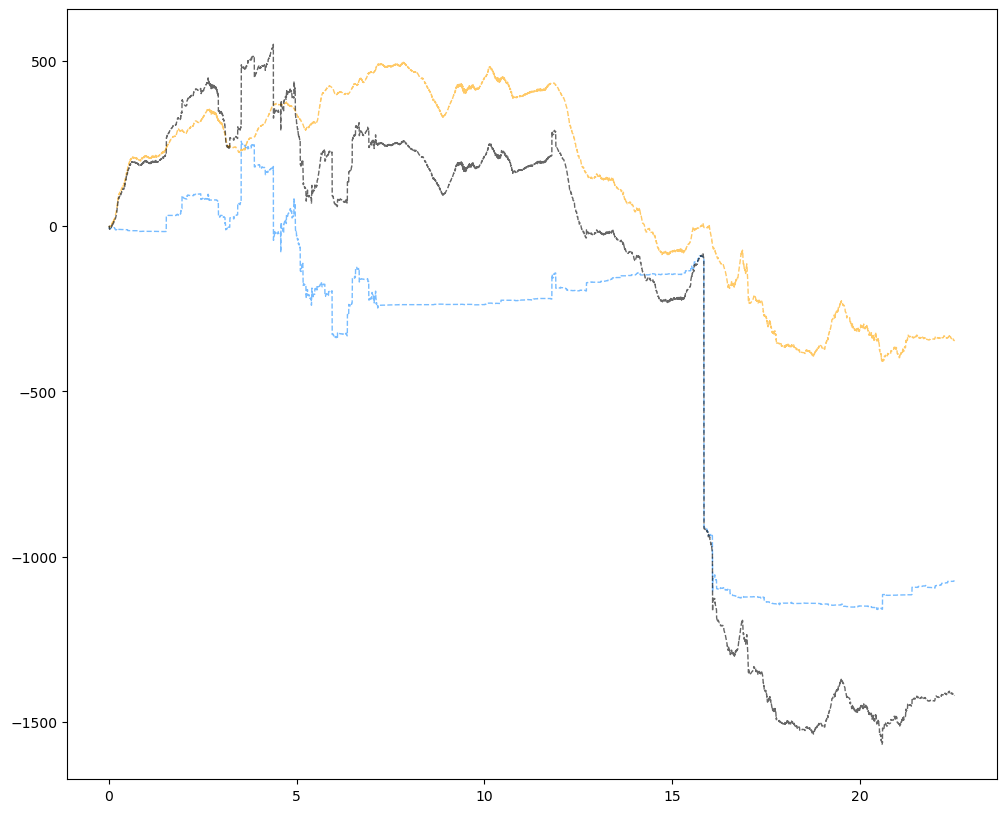

In [335]:
fig = plt.figure(figsize=(12,10))
plt.plot(dist_along_4km[:],cumsum_eddy_adv_4km,'--',color='dodgerblue', linewidth=1,alpha=0.6)
plt.plot(dist_along_4km[:],cumsum_mean_4km,'--',color='orange', linewidth=1,alpha=0.6)
plt.plot(dist_along_4km[:],cumsum_mean_4km+cumsum_eddy_adv_4km,'--',color='black', linewidth=1,alpha=0.6)


In [38]:
%%time


# 1) define variable cumsum along contour:
cumsum_mean_10km = np.cumsum(net_heat_transp_10km.mean('ocean_time').sum('s_rho'),axis=-1)* rho0*Cp*1e-12
cumsum_mean_4km = np.cumsum(net_heat_transp_4km.mean('ocean_time').sum('s_rho'),axis=-1)* rho0*Cp*1e-12
cumsum_eddy_10km = np.cumsum(np.nanmean(np.nansum(Eddy_transp_10km, axis=1),axis=0),axis=-1)*365*rho0*Cp*1e-12
cumsum_eddy2_10km = np.cumsum(np.nanmean(np.nansum(Eddy2_transp_10km, axis=1),axis=0),axis=-1)*365*rho0*Cp*1e-12
cumsum_eddy_4km = np.cumsum(np.nanmean(np.nansum(Eddy_transp_4km, axis=1),axis=0),axis=-1)*365*rho0*Cp*1e-12
cumsum_eddy2_4km = np.cumsum(np.nanmean(np.nansum(Eddy2_transp_4km, axis=1),axis=0),axis=-1)*365*rho0*Cp*1e-12
cumsum_eddy_adv_10km = np.cumsum(np.nanmean(np.nansum(Eddy_adv_10km, axis=1),axis=0),axis=-1)*rho0*Cp*1e-12
cumsum_eddy_adv_4km  = np.cumsum(np.nanmean(np.nansum(Eddy_adv_4km , axis=1),axis=0),axis=-1)*rho0*Cp*1e-12

# vol transpEddy_transp_10km; needs to multiply by 365
VT_cumsum_eddy_10km = np.cumsum(np.nanmean(np.nansum(Eddy_vol_transp_10km, axis=1),axis=0),axis=-1)*365
VT_cumsum_mean_10km = np.cumsum(vol_transport_10km.mean('ocean_time').sum('s_rho'),axis=-1)
VT_cumsum_eddy_4km = np.cumsum(np.nanmean(np.nansum(Eddy_vol_transp_4km, axis=1),axis=0),axis=-1)*365
VT_cumsum_mean_4km = np.cumsum(vol_transport_4km.mean('ocean_time').sum('s_rho'),axis=-1)


CPU times: user 3.83 s, sys: 5.31 s, total: 9.14 s
Wall time: 7.8 s


In [39]:
365*100

36500

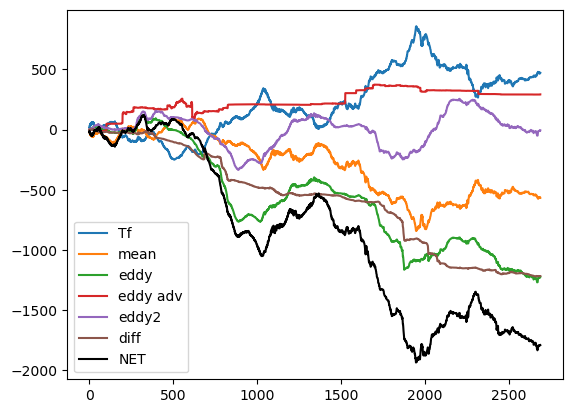

In [40]:
plt.plot(cumsum_Tf_10km,label='Tf')
plt.plot(cumsum_mean_10km,label='mean')
plt.plot(cumsum_eddy_10km,label='eddy')
plt.plot(cumsum_eddy_adv_10km,label='eddy adv')
plt.plot(cumsum_eddy2_10km,label='eddy2')
plt.plot(cumsum_eddy_10km-cumsum_eddy2_10km,label='diff')
plt.plot((cumsum_eddy_10km)+cumsum_mean_10km,'-k',label='NET')
plt.legend()